In [28]:
## Should have all the same signal processing functions from the signal package in R:
## https://cran.r-project.org/web/packages/signal/signal.pdf
from scipy.signal import butter, lfilter

## https://docs.scipy.org/doc/scipy/reference/signal.html

import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
import datetime
from scipy.signal import find_peaks

In [74]:
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_All_Data'

Define helper functions to convert from the unix timestamp to UTC and to add time to an input date based on a sample rate (will be 4hz for this code)

In [75]:
def get_utc_date_time(ts):
    return pd.to_datetime(ts, unit='s', infer_datetime_format = True)
#.strftime('%H:%M:%S:%f')

def add_fs(sample_rate, date):
    return date + datetime.timedelta(milliseconds=1.0/(sample_rate) * 1000.0)

Found some code on stack overflow and in SciPy's community website that implements a band pass butterworth filter for a 1d array: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html#.  I dont know what order filter we need for this data, but for exploratory data analysis, it appears to work ok

In [76]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

## May need to better understand which order filter is needed for this dataset
def butter_bandpass_filter(data, lowcut, highcut, fs, column_name, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    y = pd.DataFrame(y, columns=[column_name])
    return y

Helper function that will generate the list of timestamps that will be added as a new column to our dataframe

In [77]:
def time_range(df_length, start_timestamp):
    # Generate date time range based on sample rate and starting timestamp
    time_range = []
    t_0 = get_utc_date_time(float(start_timestamp))
    time_range.append(t_0)
    
    next_date = t_0
    
    for count in range(df_length-1):
        next_date = add_fs(sample_rate, next_date)
        time_range.append(next_date)
    return time_range

Helper function that returns a list of floats iterated upwards by sample rate

In [78]:
def iterate_sample_rate(df_length, fs):
    # returns list of floats starting from zero iterated upward by sample rate
    result = []
    curr_time = 0.0
    result.append(curr_time)
    
    for i in range(df_length-1):
        curr_time += 1.0/fs
        result.append(curr_time)
    return result

Helper function that finds the time difference between 2 unix timestamps

In [79]:
def t_0_diff_seconds(t_0, date_time):
    return (date_time - pd.to_datetime(t_0, unit='s', infer_datetime_format = True)).total_seconds()

Change file_path to point to where the folders containing EDA data will be

In [80]:
file_path = r'/Users/dancohen/Dropbox/E4 stuff/test data'
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_All_Data'
all_folders = glob.glob(file_path + "/PRF*")

EDA peak detection and stats about the found peaks.  Also can output graphs with the peaks labeled

In [134]:
def peak_detection_stats(data, part_id):
    peaks, features = find_peaks(data[part_id], height=(0.01, None))
    peak_list = peaks.tolist()
    # Uncomment the following lines to output graphs with peaks labeled
    #plt.figure(figsize=(30, 7))
    #plt.plot(data[part_id])
    #plt.plot(data.iloc[peak_list],'x')
    #plt.title("PRF{}".format(part_id))
    #plt.ylabel('EDA (microsiemens)')
    
    #plt.savefig(output_path+"/EDA{}.pdf".format(part_id))
    #plt.show()
    return eda_sum_stats(data.iloc[peak_list], part_id)

In [135]:
fs = 4.0 ## Sampling frequency.  This test data was gathered at 4hz
lowcut = 0.05 ## Lower bound for the filter, as directed by Empatica documentation
highcut = 1.0  ## Upper bound for the filter, as directed by Empatica documentation

Now that we have a list of file paths that each will contain the files we are interested in, we can start to do work with the csv files they contain

Helper function that calculates stats for EDA peak detection

In [138]:
def eda_sum_stats(peaks, part_id):
    #no peaks were found in this section of the data
    if(len(peaks)==0):
        peak_max = None
        peak_avg = None
        peak_num = 0
    else:    
        np_peaks = np.array(peaks[part_id])
        peak_max = np_peaks.max()
        peak_avg = np_peaks.mean()
        peak_num = len(peaks)
    stats = {part_id: [peak_max, peak_avg, peak_num]}
    names = ['Max Peak Height', 'Peak Height Avg', 'Number of Peaks']
    df = pd.DataFrame(stats)
    df['stats'] = names
    df = df.set_index('stats')
    return df

In [139]:
eda_list = []
script_1_2 = []
script_2_3 = []
script_3_end = []

# Keep track of statistics for each participant
st_1_2 = []
st_2_3 = []
st_3_end = []

for folder in all_folders:
    spl = folder.split('/')
    
    #Folder names are 'PRF###' (participant ID) and we are interested in the ID
    part_id = spl[len(spl)-1][3:]
    
    eda_df_raw = pd.read_csv(folder+"/eda.csv")
    starting_timestamp = eda_df_raw.columns[0]
    sample_rate = eda_df_raw[starting_timestamp][0]
    
    # Grab the csv containing the timestamps that mark the start and end times of the scripts
    script_times = pd.read_csv(folder+"/tags.csv", header=None)
    script_times = script_times.apply(lambda x: pd.to_datetime(x, unit='s'))
    
    try:
        begin_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[1].iat[0])
        end_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[2].iat[0])

        begin_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[3].iat[0])    
        end_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[4].iat[0])

        begin_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[5].iat[0])
        end_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[6].iat[0])
    except Exception as err:
        print("Error occurred parsing tags.csv for PRF{}.  Error: {}. This file will be skipped.".format(part_id, err))
        continue
    
    
    # Drop the first 2 rows, as we already have the timestamp and sample rate
    eda_df_raw = eda_df_raw.drop(eda_df_raw.index[0:2])
    
    # Rename the column to the participant ID
    eda_df_raw = eda_df_raw.rename(columns={starting_timestamp: part_id})
    
    # Generate data frame with timestamps iterating upwards starting at t_0
    timestamps = pd.DataFrame(time_range(len(eda_df_raw), starting_timestamp))
    
    # Generate list of timings starting from 0 iterated upwards by 1/sample rate seconds
    time_col = iterate_sample_rate(len(eda_df_raw), sample_rate)
    
    eda_df_filtered = butter_bandpass_filter(eda_df_raw[part_id], lowcut, highcut, fs, part_id)
    
    # Now, we can parse out data that we are interested in.  We will get 3 dataframes, one with data between 
    # the end of script 1 and beginning of script 2, one between the end of script 2 and beginning of script 3
    # and one that has the data from end of script 3 to the end of the timing
    eda_df_times = eda_df_filtered.copy()
        
    eda_df_times['Timestamp'] = time_col
    
    df_1_2 = eda_df_times[(eda_df_times['Timestamp'] >= end_s1) & (eda_df_times['Timestamp'] < begin_s2)]
    df_2_3 = eda_df_times[(eda_df_times['Timestamp'] >= end_s2) & (eda_df_times['Timestamp'] < begin_s3)]
    df_3_end = eda_df_times[(eda_df_times['Timestamp'] >= end_s3)]
    
    #Normalize each frame's timestamp down to 0.00 seconds once we know where the timing cutoffs for each frame are
    #See lines above
    norm_1_2 = df_1_2.iloc[0][1]
    #Make a copy here to prevent chaining assignment in the dataframe
    cp_1_2 = df_1_2.copy()
    cp_1_2['Timestamp'] = df_1_2.apply(lambda x: x['Timestamp']-norm_1_2, axis=1)
    cp_1_2 = cp_1_2.set_index('Timestamp')
    stats_1_2 = peak_detection_stats(cp_1_2, part_id)
    
    norm_2_3 = df_2_3.iloc[0][1]
    cp_2_3 = df_2_3.copy()
    cp_2_3['Timestamp'] = df_2_3.apply(lambda x: x['Timestamp']-norm_2_3, axis=1)
    cp_2_3 = cp_2_3.set_index('Timestamp')
    stats_2_3 = peak_detection_stats(cp_2_3, part_id)

    
    norm_3_end = df_3_end.iloc[0][1]
    cp_3_end = df_3_end.copy()
    cp_3_end['Timestamp'] = df_3_end.apply(lambda x: x['Timestamp']-norm_3_end, axis=1)
    cp_3_end = cp_3_end.set_index('Timestamp')
    stats_3_end = peak_detection_stats(cp_3_end, part_id)

    
    script_1_2.append(cp_1_2)
    st_1_2.append(stats_1_2)
    
    script_2_3.append(cp_2_3)
    st_2_3.append(stats_2_3)
    
    script_3_end.append(cp_3_end)
    st_3_end.append(stats_3_end)
    #Set the index to be the timestamp, so that when we concatenate the data together we get an easy join
    eda_df_times = eda_df_times.set_index('Timestamp')
    eda_list.append(eda_df_times.transpose())
    

part_id:012
43
                012
Timestamp          
0.25       0.248922
2.00       0.067518
3.50       0.158087
4.50       0.075517
5.50       0.029696
6.50       0.011919
13.25      0.069320
16.75      0.276598
17.75      0.346614
18.75      0.677883
26.50      0.207211
36.00      0.037110
38.00      0.169146
41.50      0.073536
42.00      0.075862
43.50      0.062161
47.25      0.274117
56.25      0.090383
58.00      0.078372
62.75      0.558160
77.25      0.132124
78.25      0.125594
95.50      0.027268
98.50      0.016489
100.75     0.037758
120.25     0.023121
129.00     0.012711
130.25     0.015123
131.75     0.013293
133.25     0.011204
155.00     0.013657
173.75     0.188808
175.25     0.356118
181.00     0.096440
182.00     0.079393
182.75     0.105387
183.75     0.205063
186.25     0.390404
189.75     0.114112
191.25     0.602542
192.00     0.393937
193.25     0.371945
198.75     0.211586
part_id:012
32
                012
Timestamp          
2.50       0.108403
4.00      

In [12]:
eda_all_participants = pd.concat(eda_list).transpose()

In [13]:
eda_all_participants.to_csv(output_path+"/EDA_All_Data.csv", float_format='%.6f')

Now, we can output 3 separate files representing the script timings.  One for the data between end of script 1 and beginning of script 2, one for end of script 2 and beginning of script 3 and one for end of script 3 and end of the data.

Use the axis=1 option to concatenate (defaulting to an outer join) along the timestamp axis

In [110]:
output_1_2 = pd.concat(script_1_2, axis=1)
output_2_3 = pd.concat(script_2_3, axis=1)
output_3_end = pd.concat(script_3_end, axis=1)

In [143]:
stat_1_2 = pd.concat(st_1_2, axis=1)
stat_2_3 = pd.concat(st_2_3, axis=1)
stat_3_end = pd.concat(st_3_end, axis=1)

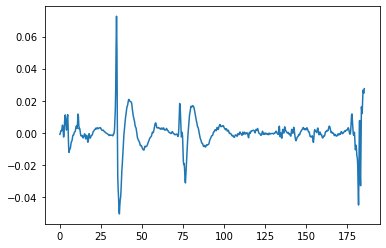

In [20]:
plt.plot(output_3_end['002'])

peaks, features = find_peaks(ibi_df[part_id], height=(0.01, None))
peak_list = peaks.tolist()

plt.scatter(ibi_df.iloc[peak_list]['Time_After_T0'], ibi_df.iloc[peak_list][part_id], c='r')
#plt.plot(output_1_2)
#plt.plot(output_2_3)
plt.show()

In [316]:
output_1_2.to_csv(output_path+"/EDA_1_2.csv", float_format='%.6f')
output_2_3.to_csv(output_path+"/EDA_2_3.csv", float_format='%.6f')
output_3_end.to_csv(output_path+"/EDA_3_end.csv", float_format='%.6f')

In [144]:
stat_1_2.to_csv(output_path+"/EDA_stats_1_2.csv", float_format='%.6f')
stat_2_3.to_csv(output_path+"/EDA_stats_2_3.csv", float_format='%.6f')
stat_3_end.to_csv(output_path+"/EDA_stats_3_end.csv", float_format='%.6f')